# Generalized CPGs


This notebook presents a general 'recipe' for constructing CPGs. 

The key insight is to decompose the CPG flow vector into a radial component, which can be represented as the gradient of a potential field, and a tangential component, which can be represented as a simple rotational vector field. 

## Requirements

First, we import the required libraries. 

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap

## Utilities

First, we define some base abstractions that will prove to be useful in constructing our general dynamical systems. 

A useful abstraction is a 2D ```VectorField```, which maps each point in ```R^2``` to a 2D vector. 

Another useful abstraction is a ```PotentialField``` which describes a 2D surface in R^3, the gradient of which can be projected back to R^2 to obtain a vector. 

In [98]:
import abc

class VectorField(abc.ABC):
    """Abstract class for a 2D vector field"""
    @abc.abstractmethod
    def get_gradient(self, x):
        """Must be implemented in Jax"""
        pass

class PotentialField(VectorField):
    """Abstract base class for a potential field"""
    @abc.abstractmethod
    def get_value(self, x):
        """Must be implemented in Jax"""
        pass
    def get_gradient_fn(self):
        return grad(self.get_value)
    def get_gradient(self, x):
        return grad(self.get_value)(x)

class FunctionalPotentialField(PotentialField):
    """Potential field parametrized by a function R^2 -> R"""
    def __init__(self, f):
        self.f = f 
    def get_value(self, x):
        return self.f(x)

class LinearCombinationVectorField(VectorField):
    def __init__(self, s1, s2, a1 = 0.5, a2 = 0.5):
        self.s1 = s1
        self.s2 = s2
        self.a1 = a1
        self.a2 = a2 
    def get_gradient(self, x):
        return self.a1 * self.s1.get_gradient(x) \
            + self.a2 * self.s2.get_gradient(x)

class LinearCombinationPotentialField(LinearCombinationVectorField):
    def get_value(self, x):
        return self.a1 * self.s1.get_value(x) \
            + self.a2 * self.s2.get_value(x)

        

To model the tangential flow, we construct a simple counterclockwise rotational field, and present a quick visualization of the resulting flow.  

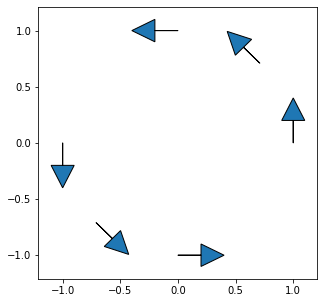

In [99]:
# Defining a general class of functions which define the
# tangential component of the CPG update. 

class SimpleRotationalField:
    def __init__(self):
        pass 
    def get_gradient(self,x):
        theta = np.arctan2(x[0], x[1])
        return np.array([-np.cos(theta), np.sin(theta)])

def test_rot_field():
    map = SimpleRotationalField()

    xs = [
        np.array([1.0, 0]),
        np.array([0, -1.0]),
        np.array([-1.0, 0]),
        np.array([0, 1.0]),
        np.array([0.71, 0.71]),
        np.array([-0.71, -0.71]),
    ]

    fig, ax = plt.subplots(figsize=(5,5))
    for x in xs:
        ax.arrow(
            *x, 
            *(map.get_gradient(x) * 0.2),
            head_width = 0.2,
            head_length = 0.2
        )

test_rot_field()

Lastly, we define some utility functions. 

In [100]:
def simulate_trajectory(
    v: VectorField,
    x0,  
    step_size = 0.01, 
    num_iters = 1000
): 
    """Simulate the trajectory obtained by gradient descent on a surface"""
    grad = None
    x = x0
    xhist = np.zeros((num_iters, x0.shape[0]))
    for i in range(num_iters):
        xhist[i] = x
        grad = d.get_gradient(x)
        x = x - step_size * grad
    return xhist

def plot_history(x_history, **subplot_kwargs):
    fig, ax = plt.subplots(**subplot_kwargs)
    ax.scatter(x_history[:,0], x_history[:,1])

## Constructing a basic CPG

Now we're ready to combine the above elements to construct a CPG out of base components. 

In [101]:
square = lambda x: jnp.dot(x, x)
inv_sq = lambda x: 1 / jnp.dot(x, x)
s1 = FunctionalPotentialField(square)
s2 = FunctionalPotentialField(inv_sq)
s3 = LinearCombinationPotentialField(s1, s2)

m = SimpleRotationalField()
d = LinearCombinationVectorField(s3, m)

We simulate the CPG update for 100 steps with step size of 0.1

In [102]:
history = simulate_trajectory(
    d, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 100)

Lastly, we visualize the resulting trajectory. 
As we can see, we have constructed a system with stable limit cycle at ```x^2 + y^2 = 1```

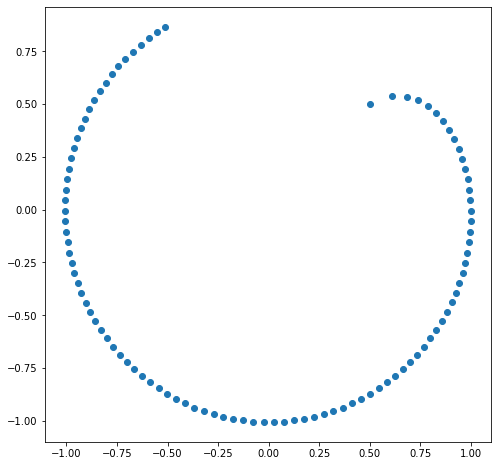

In [103]:
plot_history(history, figsize=(8,8))